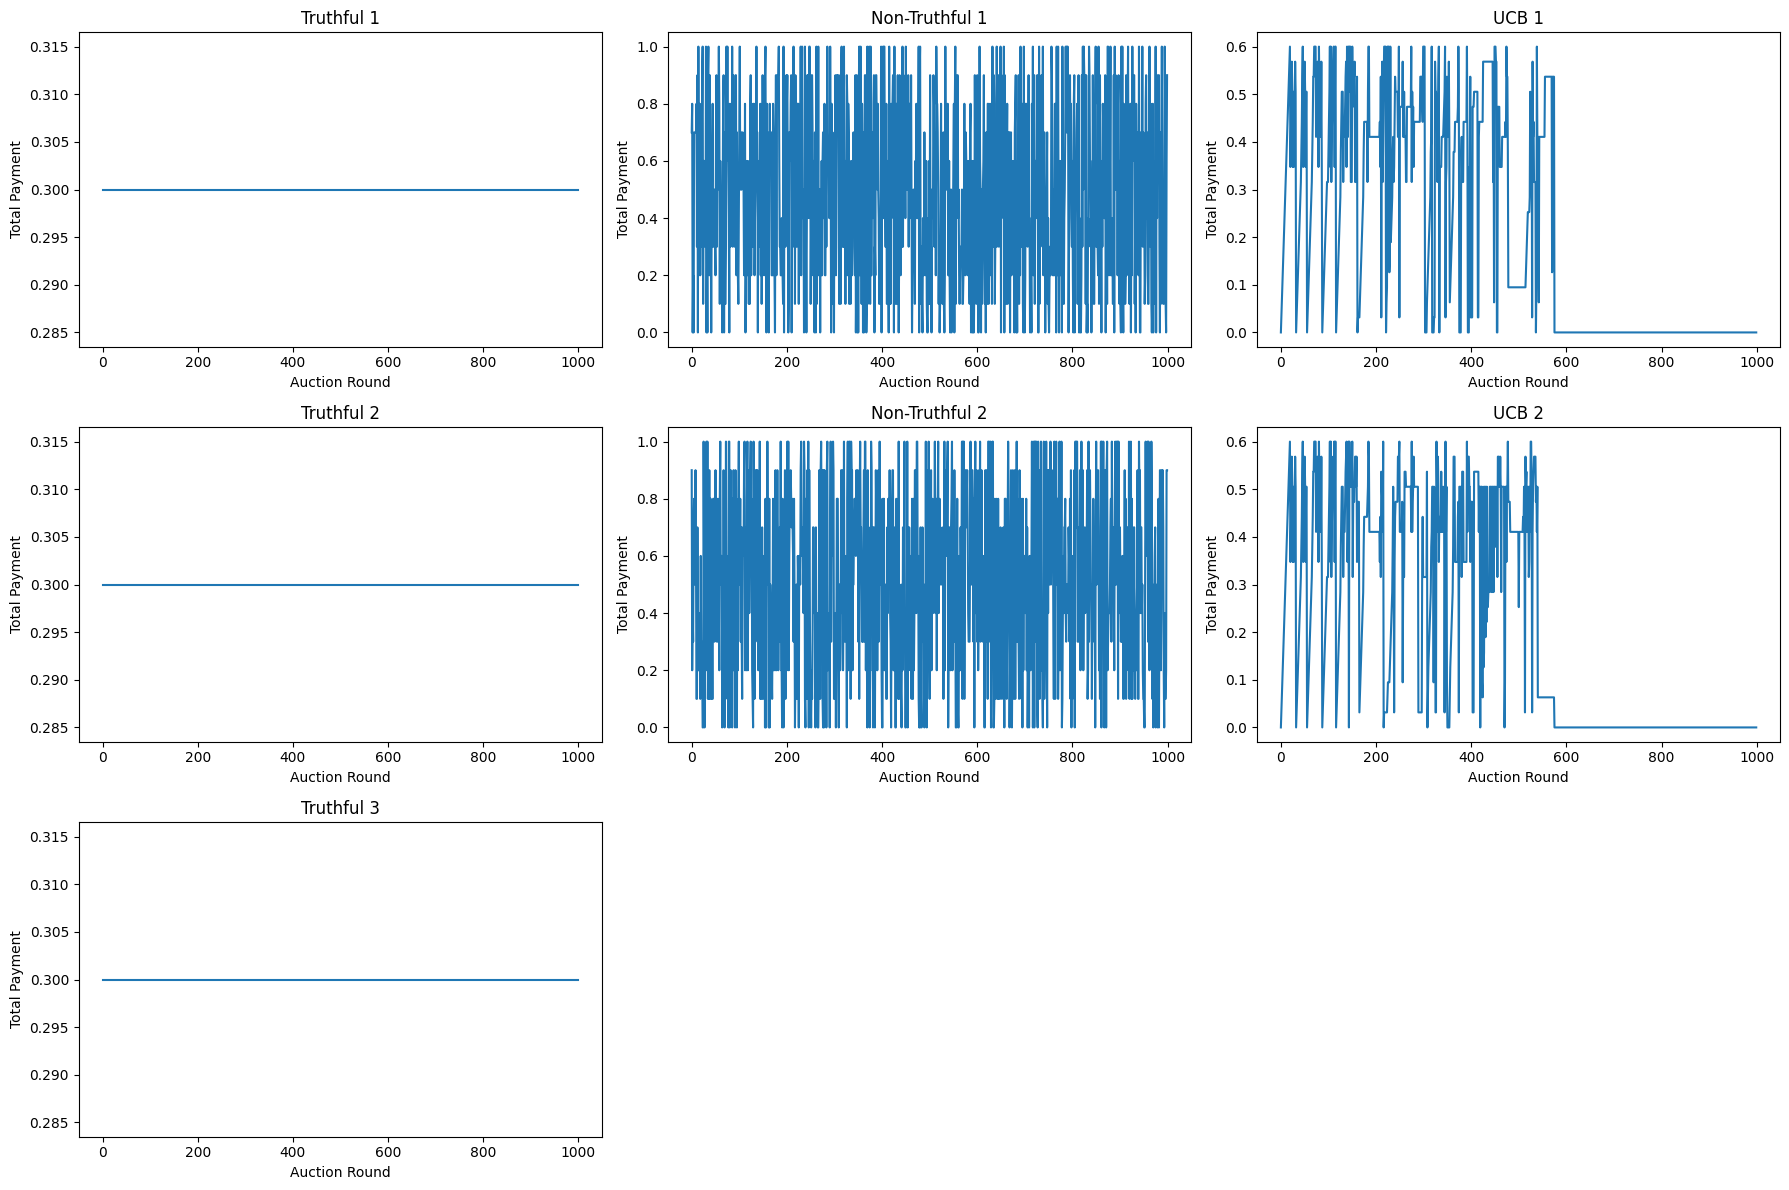

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from bidding_agents import MultiplicativePacingAgent as PrimalDualTruthful
from bidding_agents import FFMultiplicativePacingAgent as PrimalDualNonTruthful
from bidding_agents import ucblike as UCB

class FirstPriceAuction:
    def __init__(self, num_bidders):
        self.ctrs = np.ones(num_bidders) 
        self.n_adv = len(self.ctrs)

    def round(self, bids):
        winners, values = self.get_winners(bids) # Allocation mechanism
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = values[winners]/self.ctrs[winners]
        return payment.round(2)

def simulate_auction(num_bidders, budget, T, eta, valuation, bids_set):
    # Initialize the auction environment
    auction = FirstPriceAuction(num_bidders)
    
    class_instances = {
        'truthful_bidder': [],
        'non_truthful_bidder': [],
        'ucb_bidder': []
    }

    for i in range(num_bidders):
        if i % 3 == 0:
            class_instances['truthful_bidder'].append(PrimalDualTruthful(valuation, budget, T, eta))
        elif i % 3 == 1:
            class_instances['non_truthful_bidder'].append(PrimalDualNonTruthful(bids_set, valuation, budget, T, eta))
        else:
            class_instances['ucb_bidder'].append(UCB(budget, T, 1, valuation, discretization=20, range=0.1))

    # Run the auction for the specified number of rounds
    results = {
        'truthful': {i: [] for i in range(len(class_instances['truthful_bidder']))},
        'non_truthful': {i: [] for i in range(len(class_instances['non_truthful_bidder']))},
        'ucb': {i: [] for i in range(len(class_instances['ucb_bidder']))}
    }

    for t in range(T):
        bids_truthful = [instance.bid() for instance in class_instances['truthful_bidder']]
        bids_non_truthful = [instance.bid() for instance in class_instances['non_truthful_bidder']]
        bids_ucb = [instance.bid() for instance in class_instances['ucb_bidder']]

        bids = np.hstack((bids_truthful, bids_non_truthful, bids_ucb))
        winners, payments_per_click = auction.round(bids=bids)

        # Update UCB algorithm with the reward
        other_bids = np.hstack((bids_truthful, bids_non_truthful))
        my_win = int(winners in range(len(bids_truthful) + len(bids_non_truthful), len(bids)))
        m_t = other_bids.max()
        f_t, c_t = (valuation - m_t) * my_win, m_t * my_win
        for ucb_instance in class_instances["ucb_bidder"]:
            ucb_instance.update(f_t, c_t)

        # Record results per each instance
        for i, bid in enumerate(bids_truthful):
            results['truthful'][i].append(bid)
        for i, bid in enumerate(bids_non_truthful):
            results['non_truthful'][i].append(bid)
        for i, bid in enumerate(bids_ucb):
            results['ucb'][i].append(bid)
    
    return results

# Set parameters and run the simulation
num_bidders = 6 # this number can be changed to whatever you want
B = 50
T = 1000
eta = 0.1
my_valuation = 0.6
available_bids = np.linspace(0,1,11)

results = simulate_auction(num_bidders, B, T, eta, my_valuation, available_bids)

# Plot the results
total_truthful = len(results['truthful'])
total_non_truthful = len(results['non_truthful'])
total_ucb = len(results['ucb'])

num_rows = max(total_truthful, total_non_truthful, total_ucb)
num_cols = 3 

fig, ax = plt.subplots(num_rows, num_cols, figsize=(18, 4*num_rows))

# Plot Primal-Dual Truthful results
for i in range(total_truthful):
    row = i
    if total_truthful == 1:
        ax[0].plot(results['truthful'][i], label=f'Truthful {i+1}')
        ax[0].set_title(f'Truthful {i+1}')
        ax[0].set_xlabel('Auction Round')
        ax[0].set_ylabel('Total Payment')
    else:
        ax[row, 0].plot(results['truthful'][i], label=f'Truthful {i+1}')
        ax[row, 0].set_title(f'Truthful {i+1}')
        ax[row, 0].set_xlabel('Auction Round')
        ax[row, 0].set_ylabel('Total Payment')

# Plot Primal-Dual Non-Truthful results
for i in range(total_non_truthful):
    row = i
    if total_non_truthful == 1:
        ax[1].plot(results['non_truthful'][i], label=f'Non-Truthful {i+1}')
        ax[1].set_title(f'Non-Truthful {i+1}')
        ax[1].set_xlabel('Auction Round')
        ax[1].set_ylabel('Total Payment')
    else:
        ax[row, 1].plot(results['non_truthful'][i], label=f'Non-Truthful {i+1}')
        ax[row, 1].set_title(f'Non-Truthful {i+1}')
        ax[row, 1].set_xlabel('Auction Round')
        ax[row, 1].set_ylabel('Total Payment')

# Plot UCB results
for i in range(total_ucb):
    row = i
    if total_ucb == 1:
        ax[2].plot(results['ucb'][i], label=f'UCB {i+1}')
        ax[2].set_title(f'UCB {i+1}')
        ax[2].set_xlabel('Auction Round')
        ax[2].set_ylabel('Total Payment')
    else:
        ax[row, 2].plot(results['ucb'][i], label=f'UCB {i+1}')
        ax[row, 2].set_title(f'UCB {i+1}')
        ax[row, 2].set_xlabel('Auction Round')
        ax[row, 2].set_ylabel('Total Payment')

for i in range(total_truthful, num_rows):
    ax[i, 0].axis('off')
for i in range(total_non_truthful, num_rows):
    ax[i, 1].axis('off')
for i in range(total_ucb, num_rows):
    ax[i, 2].axis('off')

plt.tight_layout()
plt.show()

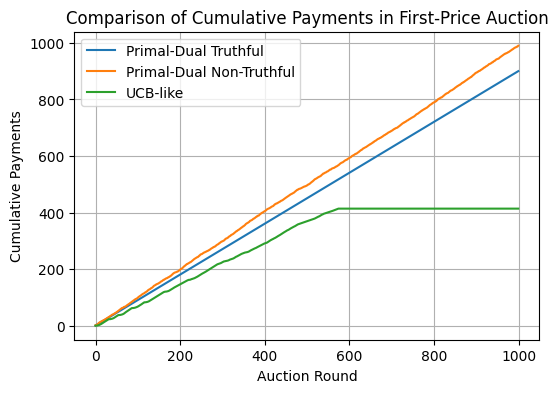

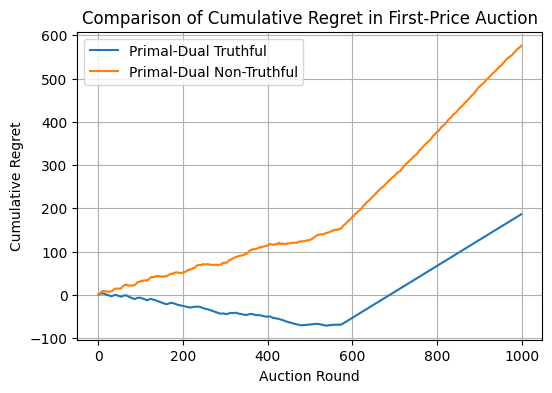

In [42]:
# Calculate cumulative payments
cumulative_payments_truthful = np.zeros(T)
cumulative_payments_non_truthful = np.zeros(T)
cumulative_payments_ucb = np.zeros(T)

for truthful_results in results['truthful'].values():
    cumulative_payments_truthful += np.cumsum(truthful_results)

for non_truthful_results in results['non_truthful'].values():
    cumulative_payments_non_truthful += np.cumsum(non_truthful_results)

for ucb_results in results['ucb'].values():
    cumulative_payments_ucb += np.cumsum(ucb_results)

# Calculate cumulative regret
cumulative_regret_truthful = np.zeros(T)
cumulative_regret_non_truthful = np.zeros(T)

for truthful_results, ucb_results in zip(results['truthful'].values(), results['ucb'].values()):
    cumulative_regret_truthful += np.cumsum(truthful_results) - np.cumsum(ucb_results)

for non_truthful_results, ucb_results in zip(results['non_truthful'].values(), results['ucb'].values()):
    cumulative_regret_non_truthful += np.cumsum(non_truthful_results) - np.cumsum(ucb_results)

# Plot the cumulative payments
plt.figure(figsize=(6, 4))
plt.plot(cumulative_payments_truthful, label='Primal-Dual Truthful')
plt.plot(cumulative_payments_non_truthful, label='Primal-Dual Non-Truthful')
plt.plot(cumulative_payments_ucb, label='UCB-like')
plt.xlabel('Auction Round')
plt.ylabel('Cumulative Payments')
plt.legend()
plt.title('Comparison of Cumulative Payments in First-Price Auction')
plt.grid(True)
plt.show()

# Plot the cumulative regret
plt.figure(figsize=(6, 4))
plt.plot(cumulative_regret_truthful, label='Primal-Dual Truthful')
plt.plot(cumulative_regret_non_truthful, label='Primal-Dual Non-Truthful')
plt.xlabel('Auction Round')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.title('Comparison of Cumulative Regret in First-Price Auction')
plt.grid(True)
plt.show()